In [2]:
using Flux, MLDatasets, ImageCore, StatsBase
using MLDatasets: MNIST
using Flux: train!, update!
using Flux: onehot, throttle, crossentropy, relu, sigmoid
using StatsBase: sample

In [3]:
using Plots
using Clustering
using JLD
using Random
using Zygote: @adjoint
using LinearAlgebra

In [4]:
using Flux
using Flux: Data.DataLoader
using Flux: onehotbatch, onecold, crossentropy
using Flux: @epochs
using Statistics
using MLDatasets

# load full training set
train_x, train_y = MNIST.traindata();

train_x_vec = [vec(train_x[:, :, i]) for i = 1:60000];
train_y_hot = [onehot(train_y[i], 0:9) for i = 1:60000];

# load full test set
test_x,  test_y  = MNIST.testdata();

test_x_vec = [vec(test_x[:, :, i]) for i = 1:10000];
test_y_hot = [onehot(test_y[i], 0:9) for i = 1:10000];

traindata = [(train_x_vec[i], train_y_hot[i]) for i = 1:60000];
testdata = [(test_x_vec[i], test_y_hot[i]) for i = 1:10000];

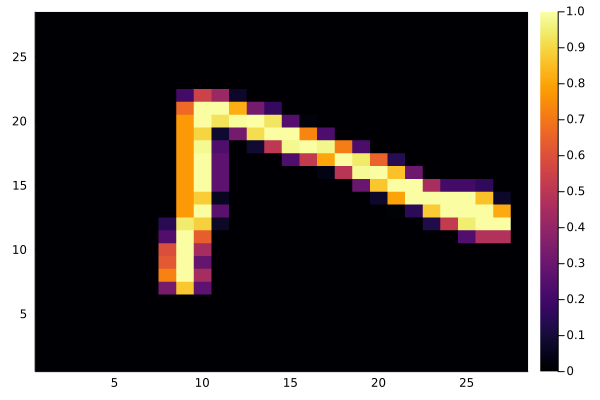

In [5]:
gr()
heatmap(test_x[:, :, 1])

In [6]:
# models could be a list of models with the same structure but different parameters
# then in the function call I could choose a random model from the list and apply the
# reparameterization to that model
# To implement a todo above, I could make A trainable but make it a scalar value and add it to the loss
mutable struct PermutationModel
    model::Any # maybe change this type to Array{Any}
    parameters::Vector{Float64}
end

# Overload call, so the object can be used as a function
function (m::PermutationModel)(x)
    p, restruct = Flux.destructure(m.model)
    
    shuffle!(m.parameters)
    
    reparam_model = restruct(m.parameters)
    return reparam_model(x)
end

In [25]:
input_size = 784;
output_size = 16;

In [26]:
model = Chain(
    Dense(input_size, output_size, relu),
    Dense(output_size, 10),
    softmax
)

Chain(
  Dense(784, 16, relu),                 # 12_560 parameters
  Dense(16, 10),                        # 170 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 12_730 parameters, 49.977 KiB.

In [27]:
function loss(x, y)
    return Flux.Losses.crossentropy(x, y)
end
accuracy(x, y) = mean(onecold.(x) .== onecold.(y))

accuracy (generic function with 1 method)

In [33]:
#loss(x, y) = Flux.Losses.crossentropy(data_model(x), y)
opt = ADAM(.001)
ps = Flux.params(model)

# I can just unroll the update!
# function and write out the parameter updates myself, so that all parameters are updated in the same way.

# TODO
# Should maybe look into the variance chosen specially for feedforward models implemented in Flux
num_runs = 1
for j in 1:num_runs
    trainsample = sample(traindata, 30, replace=false);

    epochs = 200
    for epoch in 1:epochs
        loss_total = 0
        for (i, d) in enumerate(trainsample)
            shuffled_ps = copy(ps)
            
            for p in shuffled_ps
                
            end
            # TODO
            # Choose small random sub sample from n sample above and provide to the loss function
            gs = gradient(shuffled_p) do
              shuffled_model = restruct(shuffled_p)
              training_loss = loss(shuffled_model(d[1]), d[2])
              # Code inserted here will be differentiated, unless you need that gradient information
              # it is better to do the work outside this block.
              return training_loss
            end
            loss_total += loss(model(d[1]), d[2])
            if i%10==0
                println(loss_total/i)
            end
            # Insert whatever code you want here that needs training_loss, e.g. logging.
            # logging_callback(training_loss)
            # Insert what ever code you want here that needs gradient.
            # E.g. logging with TensorBoardLogger.jl as histogram so you can see if it is becoming huge.
            update!(opt, ps, gs)
        end
        println(epoch)
    end
    print("NUMBER OF RUNS: ")
    println(j)
    print("ACCURACY: ")
    println(accuracy(model.(test_x_vec), test_y_hot))
end

LoadError: MethodError: no method matching (::var"#43#44"{Tuple{Vector{N0f8}, Flux.OneHotArray{UInt32, 10, 0, 1, UInt32}}, Vector{Float32}, Flux.var"#60#62"{Chain{Tuple{Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, typeof(softmax)}}}})(::Vector{Float32})
[0mClosest candidates are:
[0m  (::var"#43#44")() at In[33]:24